#### Summary:
In this notebook I will test running FINRICH on different sets of linked cREs, to test for enrichment of GWAS variants.

# 1. Basic Preparation

In [1]:
# Import necessary libraries
suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(grid))

suppressMessages(library(tictoc))
suppressMessages(library(UpSetR))
suppressMessages(library(ggplot2))
#suppressMessages(library(cicero))
#suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))

suppressMessages(library(parallel))

In [2]:
# Define celltypes list
celltypes <- c('beta','alpha','delta','gamma','ductal','acinar')

# Define colors for each celltype (same order as celltypes)
colors <- c('#3F98E0', '#F51646', '#E39E14', '#A1D99B', '#09850B', '#F5DE6C')

In [3]:
# Define names and colors for link methods
link_methods <- c('SMORES', 'ABC', 'Cicero')
link_colors <- c('#E151A7', '#1D8BDF', '#DEBE1D')
names(link_colors) <- link_methods

# Define overlap sets and colors
link_sets <- c('hm_abc_cic', 'hm_abc', 'hm_cic', 'abc_cic', 'hm', 'abc', 'cic')
overlap_colors <- c('#000000', #All 3 links (black)
                    '#7F6EC3', #HM + ABC (orange)                    
                    '#E08862', #HM + Cicero (purple)
                    '#7EA57E', #ABC + Cicero (green)
                    '#E151A7', #HM (pink)
                    '#1D8BDF', #ABC (blue)
                    '#DEBE1D') #Cicero (yellow)
names(overlap_colors) <- link_sets

In [4]:
distance_bins <- c('250000-1000000', '100000-250000', '50000-100000', '10000-50000', '0-10000')

In [5]:
# disable scientific notation for the filepath names of larger distances
options(scipen = 999)
set.seed(8)

### Important file paths

In [6]:
#significant links are in one file now
# sig links (w header) = links_dir + celltype + links_suffix
links_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/method_overlaps/231211_links_summary'
links_suffix <- '_all_methods_links.wHeader.bedpe'

In [7]:
#background links are in different places 
# SMORES links (CP cut) = hm_prefix + celltype + hm_suffix
hm_prefix <- '/nfs/lab/hmummey/multiomic_islet/intermediates/230228_SMORES_PP_investigation/less_cols/'
hm_suffix <- '_all_CP_links.bedpe'

# ABC background files = abc_bg_dir + celltype + abc_bg_suffix
abc_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/run_abc/reprocessed_outputs/230110_allCTs/nonsig_links/'
abc_bg_suffix <- '_nonsig_mapped_links.bedpe'

# Cicero background files = cic_bg_dir + celltype + cic_bg_suffix
cic_bg_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/cicero/230111_final_map/reprocessed_all_links/'
cic_bg_suffix <- '_links.final_filt.bedpe'

In [8]:
peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/recluster_final_majorCTs_v2'

In [9]:
# #collect hg38 finemapping bed files (T1D and T2D)
# t1d_old <- "/nfs/lab/T1D_Nov21/T1D_meta.compiled_credsets.hg38.bed"
# #t1d_new <- "" #don't use new fine mapping yet
# t2d <- "/nfs/lab/relgamal/T1D_T2D_GWAS/DIAMANTE_T2D.credset.hg38.bed"

# # #glycemic trait credset beds prepped here: /nfs/lab/hmummey/multiomic_islet/notebooks/240311_Map_GWAS_to_hg38_%2Bget_lead_variants.ipynb
# # hba1c_sinott_armstrong <- '/nfs/lab/projects/multiomic_islet/references/credible_sets/HbA1c_Sinnott_Armstrong_99_credset_hg38.bed'
# # fg_dicorpo <- '/nfs/lab/projects/multiomic_islet/references/credible_sets/DiCorpo_2022_95_credset_hg38_FG.bed'
# # fi_dicorpo <- '/nfs/lab/projects/multiomic_islet/references/credible_sets/DiCorpo_2022_95_credset_hg38_FI.bed'

# #alt glycemic traits: use the MAGIC lead variants mapped over... should be comparable?
# hba1c_magic <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/lead_variants/HbA1c_MAGIC_lead_variants_reformat_hg38.bed'
# fg_magic <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/lead_variants/FG_MAGIC_lead_variants_reformat_hg38.bed'
# fi_magic <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/lead_variants/FI_MAGIC_lead_variants_reformat_hg38.bed'

In [10]:
#final credible set files!
credset_dir <- '/nfs/lab/projects/multiomic_islet/references/hg38_GWAS/credsets'
t1d_fp <- file.path(credset_dir,'T1D_Chiou_2021_cred_set.bed')
t2d_fp <- file.path(credset_dir,'T2D_DIAMANTE_multiancestry.cred99.hg38.bed')
glu2h_fp <- file.path(credset_dir,'2hGlu_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fg_fp <- file.path(credset_dir,'FG_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
fi_fp <- file.path(credset_dir,'FI_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')
hba1c_fp <- file.path(credset_dir,'HbA1c_MAGIC_trans_ancestry_pseudo_credset.LDproxyRsq0.8.bed')

In [11]:
gwas_prefixes <- c('T1D','T2D','2hGlu','FG','FI','HbA1c')
gwas_fps <- c(t1d_fp, t2d_fp, glu2h_fp, fg_fp, fi_fp, hba1c_fp)
names(gwas_fps) <- gwas_prefixes

In [12]:
outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/cRE-gene_links/FINRICH/240701_final_FINRICH'

# 1. FINRICH Prereqs:

Install finrich: `pip3 install finrich` (https://pypi.org/project/finrich/)

Rebecca's Script: `/nfs/lab/rlmelton/npod/notebooks/sherlock/Downstream_analysis_nPOD_april2022/Publication/Final_Downstream/Finrich/20220920_allCelltypes_Finrich.sh`

Example FINRICH call from her script
```
cd /nfs/lab/rlmelton/npod/notebooks/sherlock/Downstream_analysis_nPOD_april2022/HumanGenetics/20220920_${cell}/

T1Dfinemap="/nfs/lab/T1D_Nov21/T1D_meta.compiled_credsets.hg38.bed"
testing_signal="20220920_${cell}_${motif}_signal.txt"
background_signal="20220920_${cell}_${motif}_background.txt"

finrich ${T1Dfinemap} ${testing_signal} ${background_signal}  --permutations 1000 --processes 2 > out.txt

#also need overall outputs file to concatenate everything into
awk -v motif=${motif}  'NR == 1 {print motif "|" $0;}' out.txt > ${output_file}
rm out.txt

```

FINRICH inputs:
- finemapped variants bed file
- background.txt (bed file of peaks, tab separated, 3 cols)
- signal.txt (bed file of peaks, tab separated, 3 cols)

## Check the overlap of cRE sets and credible sets
It's important to do this, because otherwise FINRICH just won't run

In [12]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
check_overlap <- function(finemap_bed, bed_fp, log_fp){
    system(sprintf('echo %s >> %s', bed_fp, log_fp))
    cmd <- sprintf('bedtools intersect -a %s -b %s -wa -wb | wc -l >> %s', bed_fp, finemap_bed, log_fp)
    system(cmd)
}

In [13]:
log_dir <- file.path(outdir,'credset_overlaps')
dir.create(log_dir, showWarnings=FALSE)

## Check overall overlap between cell type peak calls and credible sets (T1D and T2D, glycemic)
--> NOT GREAT overlap between either sets and the fasting glucose/fasting insulin credsets...

### Union peaks

In [14]:
great_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/GREAT'

for (celltype in celltypes){
    ct_peaks <- file.path(great_dir, 'ct_peaks', sprintf('%s_union_peaks.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_UNION_peaks.T1D_overlap.txt')
    check_overlap(t1d_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_UNION_peaks.T2D_overlap.txt')
    check_overlap(t2d_fp, ct_peaks, log2)
}

In [15]:
great_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/trait_associations/240327_final_associations/ATAC/GREAT'

for (celltype in celltypes){
    ct_peaks <- file.path(great_dir, 'ct_peaks', sprintf('%s_union_peaks.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_UNION_peaks.HbA1c_overlap.txt')
    check_overlap(hba1c_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_UNION_peaks.FI_overlap.txt')
    check_overlap(fi_fp, ct_peaks, log2)
    log3 <- file.path(log_dir,'all_ct_UNION_peaks.FG_overlap.txt')
    check_overlap(fg_fp, ct_peaks, log3)
    log4 <- file.path(log_dir,'all_ct_UNION_peaks.2hGlu_overlap.txt')
    check_overlap(glu2h_fp, ct_peaks, log4)
}

### Merged peaks

In [16]:
peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/recluster_final_majorCTs_v2'

for (celltype in celltypes){
    ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_MERGED_peaks.T1D_overlap.txt')
    check_overlap(t1d_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_MERGED_peaks.T2D_overlap.txt')
    check_overlap(t2d_fp, ct_peaks, log2)
}

In [17]:
peak_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/call_peaks/recluster_final_majorCTs_v2'

for (celltype in celltypes){
    ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
    log1 <- file.path(log_dir,'all_ct_MERGED_peaks.HbA1c_overlap.txt')
    check_overlap(hba1c_fp, ct_peaks, log1)
    log2 <- file.path(log_dir,'all_ct_MERGED_peaks.FG_overlap.txt')
    check_overlap(fg_fp, ct_peaks, log2)
    log3 <- file.path(log_dir,'all_ct_MERGED_peaks.FI_overlap.txt')
    check_overlap(fi_fp, ct_peaks, log3)
    log4 <- file.path(log_dir,'all_ct_MERGED_peaks.2hGlu_overlap.txt')
    check_overlap(glu2h_fp, ct_peaks, log4)
}

## Check overall overlap between per method linked cRE calls and credible sets (T1D and T2D)

In [18]:
for (celltype in celltypes){
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract method links AND remove annoying columns
    hm_links <- subset(sig_links, !is.na(hm_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    abc_links <- subset(sig_links, !is.na(abc_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    cic_links <- subset(sig_links, !is.na(cic_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)

    #write these links to temp bed files
    fp1 <- file.path(log_dir,sprintf('SMORES_%s.bed',celltype))
    write.table(hm_links, fp1, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp2 <- file.path(log_dir,sprintf('ABC_%s.bed',celltype))
    write.table(abc_links, fp2, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp3 <- file.path(log_dir,sprintf('Cicero_%s.bed',celltype))
    write.table(cic_links, fp3, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
    #then check for overlaps
    log1 <- file.path(log_dir,'ct_linked_cREs.T1D_overlap.txt')
    check_overlap(t1d_fp, fp1, log1)
    check_overlap(t1d_fp, fp2, log1)
    check_overlap(t1d_fp, fp3, log1)
    
    log2 <- file.path(log_dir,'ct_linked_cREs.T2D_overlap.txt')
    check_overlap(t2d_fp, fp1, log2)
    check_overlap(t2d_fp, fp2, log2)
    check_overlap(t2d_fp, fp3, log2)

    #and delete temp files
    system(sprintf('rm %s %s %s',fp1,fp2,fp3))
    
}

# 2. Run FINRICH on sets of linked cREs

In [19]:
### Function to run FINRICH on all sets of sig results (will just use files from GREAT)
### similar to great I'm going to just write all the commands to a script and then run that in the terminal
run_FINRICH <- function(finemap_bed, prefix, cre_bed, bg_bed, out_dir){
    #create overall output file
    overall_out_fp <- file.path(out_dir,'combined_results.txt')
    
    #set up finrich code
    temp_fp <- file.path(out_dir, paste0(prefix,'_temp.txt'))
    cmd <- sprintf('finrich %s %s %s --permutations 1000 --processes 2 > %s', finemap_bed, cre_bed, bg_bed, temp_fp)
    #print(cmd)
    system(cmd)

    #concat and reformat outputs slightly
    cmd2 <- sprintf('awk -v prefix=%s \'NR == 1 {print prefix "|" $0;}\' %s >> %s', prefix, temp_fp, overall_out_fp)
    system(cmd2)
    system(sprintf('rm %s',temp_fp))
}

## 2a. Run on all linked cREs

In [25]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
run_finrich_all_links_gen <- function(celltype, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir, gwas_prefix)
    dir.create(gwas_dir, showWarnings=FALSE, recursive=TRUE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract method links AND remove annoying columns
    hm_links <- subset(sig_links, !is.na(hm_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    abc_links <- subset(sig_links, !is.na(abc_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
    cic_links <- subset(sig_links, !is.na(cic_score)) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)

    #write these links to temp bed files
    fp1 <- file.path(outdir,sprintf('SMORES_%s.bed',celltype))
    write.table(hm_links, fp1, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp2 <- file.path(outdir,sprintf('ABC_%s.bed',celltype))
    write.table(abc_links, fp2, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    fp3 <- file.path(outdir,sprintf('Cicero_%s.bed',celltype))
    write.table(cic_links, fp3, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
    #run finrich with helper function
    ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
    run_FINRICH(gwas_fp, paste('SMORES',celltype,sep='-'), fp1, ct_peaks, gwas_dir)
    run_FINRICH(gwas_fp, paste('ABC',celltype,sep='-'), fp2, ct_peaks, gwas_dir)
    run_FINRICH(gwas_fp, paste('Cicero',celltype,sep='-'), fp3, ct_peaks, gwas_dir)
    
    #and delete temp files
    #system(sprintf('rm %s %s %s',fp1,fp2,fp3))
}

In [28]:
res_dir1 <- file.path(outdir, 'all_links')
dir.create(res_dir1, showWarnings=F)

In [30]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(celltypes, run_finrich_all_links_gen, gwas_prefix, gwas_fp, res_dir1)
}

[1] "T1D 2024-07-02 20:39:42"
[1] "T2D 2024-07-02 20:50:10"
[1] "2hGlu 2024-07-02 20:53:29"
[1] "FG 2024-07-02 20:54:37"
[1] "FI 2024-07-02 20:56:14"
[1] "HbA1c 2024-07-02 20:57:33"


## 2b. Run on all sets of method overlaps

In [31]:
### Function to run FINRICH on a cell type (so I can parallelize by cell type)
### slightly modified to run for method overlap link sets
run_finrich_method_overlaps_gen <- function(celltype, gwas_prefix, gwas_fp, outdir){
    #set up file paths
    gwas_dir <- file.path(outdir, gwas_prefix)
    dir.create(gwas_dir, showWarnings=FALSE, recursive=TRUE)
    
    #read in overall links methods
    sig_links_fp <- paste0(links_dir, '/', celltype, links_suffix)
    sig_links <- read.table(sig_links_fp, sep='\t', header=1)
    
    #extract each overlap set and run FINRICH separately
    for(set in link_sets){
        #extract links and write to temp bed file
        sig_links_cut <- subset(sig_links, method_str==set) %>% select(-c(hm_score,abc_score,cic_score,method_str)) %>% distinct(chr,start,end)
        fp <- file.path(outdir, sprintf('%s_%s.bed',celltype,set))
        write.table(sig_links_cut, fp, sep='\t', row.names=FALSE, col.names=FALSE, quote=FALSE)
    
        #run finrich with helper function
        ct_peaks <- file.path(peak_dir, sprintf('%s.merged_peaks.anno.mergedOverlap.bed',celltype))
        run_FINRICH(gwas_fp, paste(set,celltype,sep='-'), fp, ct_peaks, gwas_dir)

        #delete temp file
        system(sprintf('rm %s',fp))
    }
}

In [32]:
res_dir2 <- file.path(outdir, 'method_overlaps')
dir.create(res_dir2, showWarnings=F)

In [33]:
for(gwas_prefix in names(gwas_fps)){
    print(paste(gwas_prefix, Sys.time()))
    gwas_fp <- gwas_fps[[gwas_prefix]]
    mclapply(celltypes, run_finrich_method_overlaps_gen, gwas_prefix, gwas_fp, res_dir2)
}

[1] "T1D 2024-07-02 20:59:08"
[1] "T2D 2024-07-02 21:23:41"
[1] "2hGlu 2024-07-02 21:30:03"
[1] "FG 2024-07-02 21:31:38"
[1] "FI 2024-07-02 21:34:25"
[1] "HbA1c 2024-07-02 21:36:19"


# Parse in results files
What FINRICH does (based on looking through the [code here](https://gitlab.com/aaylward/finrich/-/blob/master/finrich/finrich.py?ref_type=heads): intersects the background peaks and peaks of interest with the finemapping set (counts number of intersections). Then creates an empirical distribution by randomly sampling the background down to the size of the peaks of interest set and counting finemap intersections. Then compares the mean of this empirical distribution to the actual value from the peaks of interest.

What the results are:
- pval: sum(val >= observed_val for val in empirical_dist) / permutations
- fold_enrich: fold change (observed/empirical mean)
- logOR: log_odds(empirical mean)
- conf_lower: log_odds(confidence interval upper)
- conf_upper: log_odds(confidence interval lower)

Where log_odds = 
```
    def log_odds(val):
        if val == 0 or observed_val == max_val:
            return float('inf')
        if val == max_val or observed_val == 0:
            return float('-inf')
        return (
            log(observed_val)
            + log(max_val - val)
            - log(max_val - observed_val)
            - log(val)
        )
```

In [16]:
### function to parse results from FINRICH
parse_finrich_res <- function(finrich_fp, num_id_cols){
    df <- suppressMessages(vroom::vroom(finrich_fp, col_names=FALSE))
    
    #reformat everything with dplyr
    df <- df %>% select(X1,X2,X4,X6,X8,X10) %>%
            `colnames<-`(c('id','pval','fold_enrich','logOR','conf_lower','conf_upper'))
    df$id <- gsub('\\|\\{"pval":','',df$id)
    df$conf_upper <- as.numeric(gsub('}','',df$conf_upper))
    
    #extract info from id
    id_extend <- as.data.frame(str_split_fixed(df$id, '-', num_id_cols))
    if(num_id_cols==2) colnames(id_extend) <- c('method','celltype')
    if(num_id_cols==3) colnames(id_extend) <- c('method','celltype','distance')
    df2 <- cbind(df, id_extend)
    
    #write to file for easy plotting
    out_fp <- gsub('\\.txt','_reformat\\.txt',finrich_fp)
    write.table(df2, out_fp, sep='\t', row.names=F, quote=F)
}

### All linked cREs

In [17]:
indir <- res_dir1
fp1 <- file.path(indir, 'T1D', 'combined_results.txt')
fp2 <- file.path(indir, 'T2D', 'combined_results.txt')

parse_finrich_res(fp1, 2)
parse_finrich_res(fp2, 2)

In [18]:
indir <- res_dir1
fp1 <- file.path(indir, '2hGlu', 'combined_results.txt')
fp2 <- file.path(indir, 'FG', 'combined_results.txt')
fp3 <- file.path(indir, 'FI', 'combined_results.txt')
fp4 <- file.path(indir, 'HbA1c', 'combined_results.txt')

parse_finrich_res(fp1, 2)
parse_finrich_res(fp2, 2)
parse_finrich_res(fp3, 2)
parse_finrich_res(fp4, 2)

### Method set cREs

In [20]:
res_dir2 <- file.path(outdir, 'method_overlaps')

In [21]:
indir <- res_dir2
fp1 <- file.path(indir, 'T1D', 'combined_results.txt')
fp2 <- file.path(indir, 'T2D', 'combined_results.txt')

parse_finrich_res(fp1, 2)
parse_finrich_res(fp2, 2)

In [22]:
indir <- res_dir2
fp1 <- file.path(indir, '2hGlu', 'combined_results.txt')
fp2 <- file.path(indir, 'FG', 'combined_results.txt')
fp3 <- file.path(indir, 'FI', 'combined_results.txt')
fp4 <- file.path(indir, 'HbA1c', 'combined_results.txt')

parse_finrich_res(fp1, 2)
parse_finrich_res(fp2, 2)
parse_finrich_res(fp3, 2)
parse_finrich_res(fp4, 2)

# Make enrichment plots

In [23]:
### dedicated plotting function
plot_finrich <- function(fp, colors, select_ids, title, sig_cutoff=0.1){
    # Read in table of FINRICH results (reformatted)
    data <- read.table(fp, sep='\t', header = TRUE)
    row.names(data) <- data$id
    data <- data %>% subset(id %in% select_ids & logOR !=Inf & logOR !=-Inf)
    data$color <- colors[data$id] 
    data$qval <- p.adjust(data$pval, method='BH')
    
    # Sort data_cut by celltype (use to refactor later on) -- maybe don't do this
    data_cut_sort <- data[order(data$method, data$celltype),]
    
    # Prepare strings for y-labels (get rid of underscore in rownames)
    y_labels <- rev(gsub('_', ' ', data_cut_sort$id))
    xmax <- ceiling(max(data_cut_sort$fold_enrich) + 0.5)
    data_cut_sort$sig <- ifelse(data_cut_sort$qval < sig_cutoff, '*', '')
        
    # Make a forest plot with the subsetted data
    options(repr.plot.width = 6, repr.plot.height = 6)
    theme_set(
        theme_classic())

    p1 <- ggplot(data=data_cut_sort, aes(x=fold_enrich, y=id, fill=color)) + 
            geom_vline(xintercept=seq(0, xmax, 1), linetype='dashed', color='black', alpha=0.5, size=0.5) + 
            geom_bar(stat='identity', fill=colors[data_cut_sort$id]) + 
            geom_vline(xintercept=1, color='black', size=0.5) + 
            geom_text(aes(fold_enrich, id, label=sig), position=position_dodge(width=0.6), size=10, hjust=-1) +
            xlim(0,xmax) + scale_y_discrete(labels=y_labels) + 
            xlab('Fold enrichment') + ylab('Linked cRE set') + labs(title=title) + 
            theme(plot.title=element_text(size=18, hjust=0.5),
                  axis.text.x=element_text(size=15, vjust=0.5),
                  axis.text.y=element_text(size=15, vjust=0.5),
                  axis.title.x = element_text(size=18, vjust=-0.35),
                  axis.title.y = element_text(size=18, vjust=0.5),
                  legend.position = "none", panel.border=element_rect(color='black',fill=NA, size=1))    
    p1$data$id <- factor(x = p1$data$id, levels=rev(data_cut_sort$id))
    print(p1)
}

### All links results

In [24]:
colors1 <- rep(link_colors, length(celltypes))
names(colors1) <- paste(link_methods, rep(celltypes,each=3), sep='-')
colors1

SMORES-beta      ABC-beta   Cicero-beta  SMORES-alpha     ABC-alpha 
    "#E151A7"     "#1D8BDF"     "#DEBE1D"     "#E151A7"     "#1D8BDF" 
 Cicero-alpha  SMORES-delta     ABC-delta  Cicero-delta  SMORES-gamma 
    "#DEBE1D"     "#E151A7"     "#1D8BDF"     "#DEBE1D"     "#E151A7" 
    ABC-gamma  Cicero-gamma SMORES-ductal    ABC-ductal Cicero-ductal 
    "#1D8BDF"     "#DEBE1D"     "#E151A7"     "#1D8BDF"     "#DEBE1D" 
SMORES-acinar    ABC-acinar Cicero-acinar 
    "#E151A7"     "#1D8BDF"     "#DEBE1D"

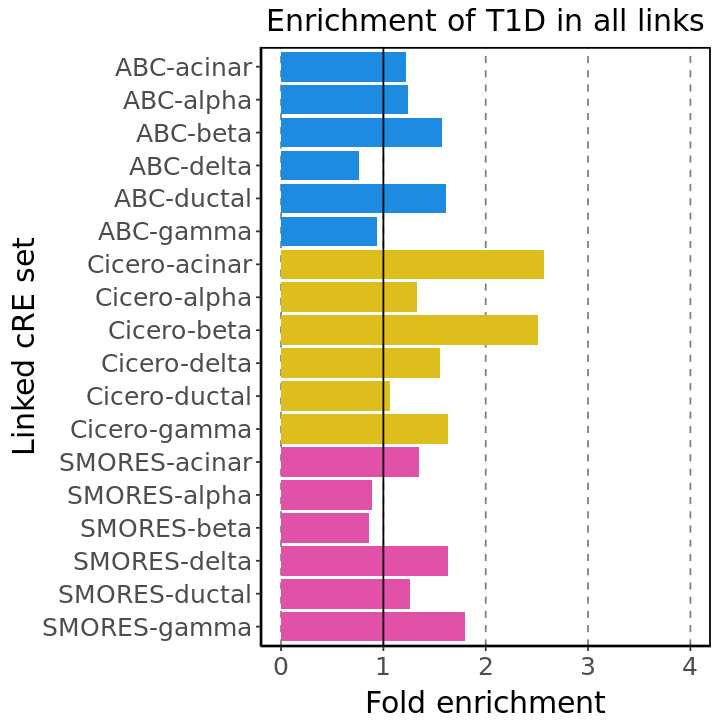

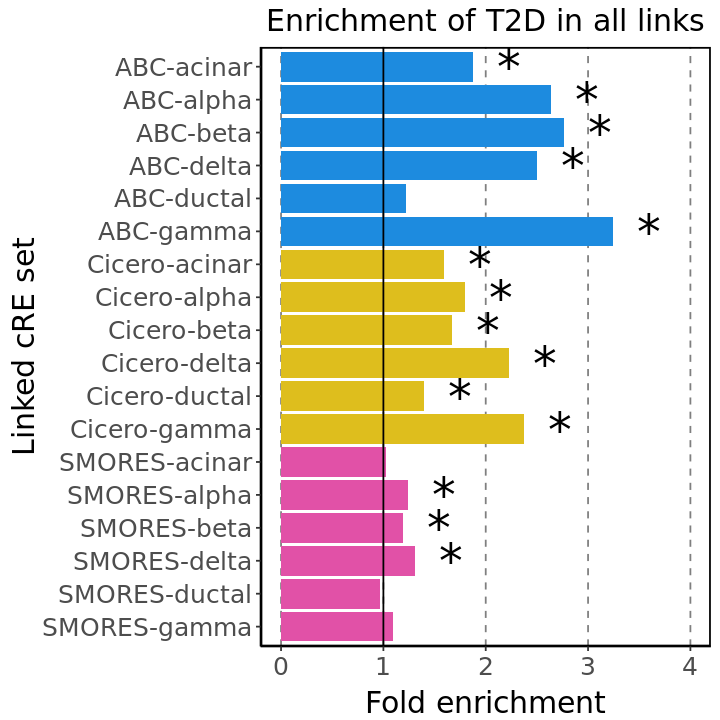

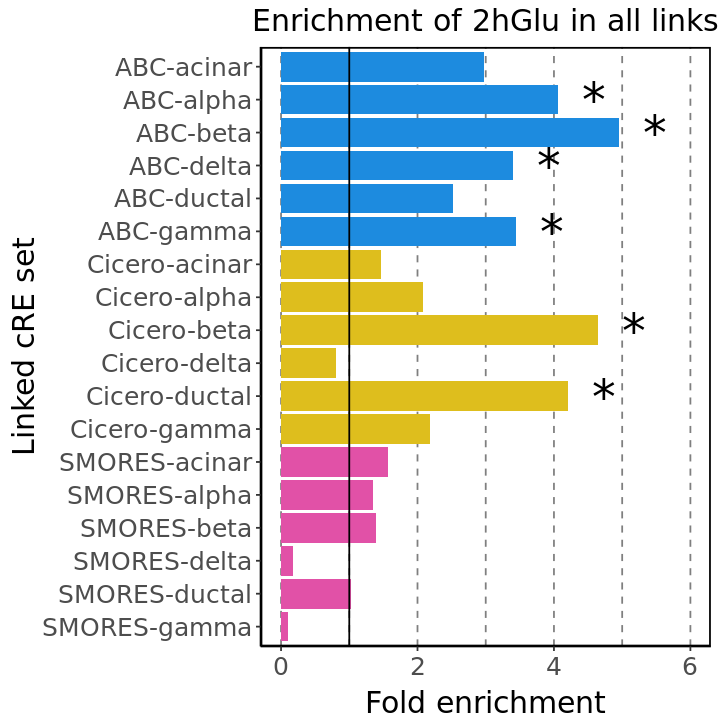

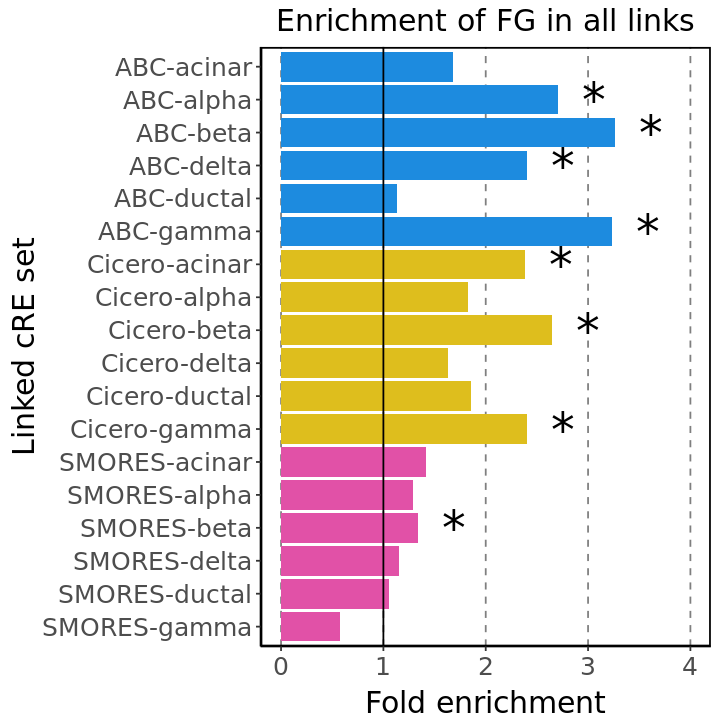

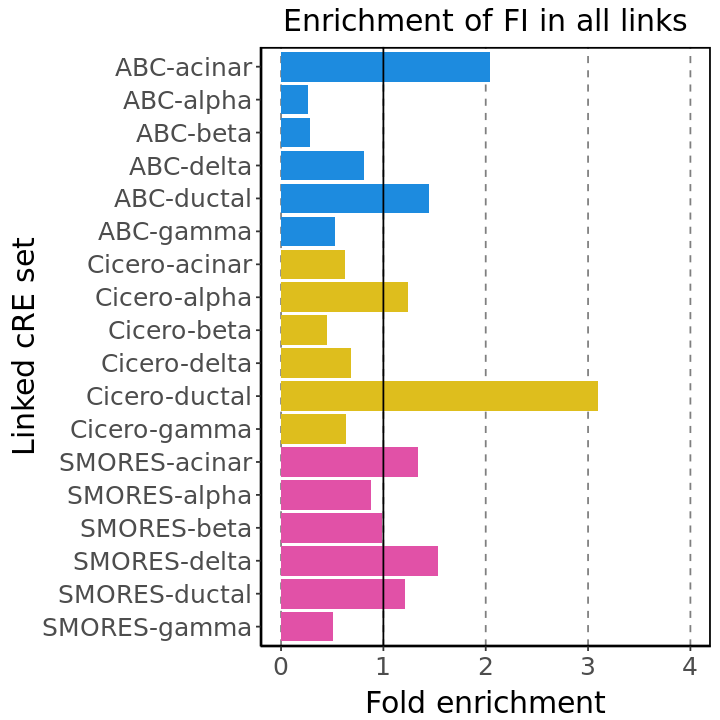

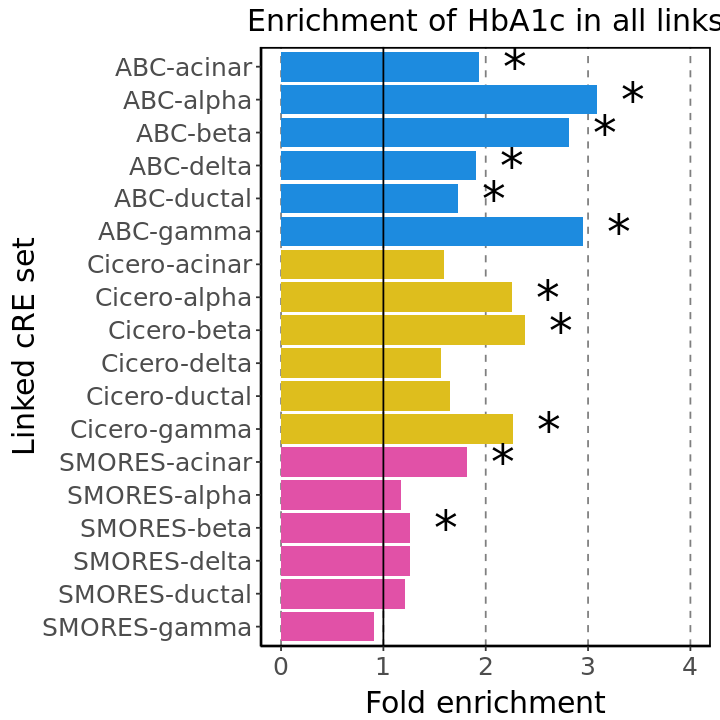

In [26]:
res_dir1 <- file.path(outdir, 'all_links')
indir <- res_dir1

for(gwas_prefix in gwas_prefixes){
    fp <- file.path(indir,gwas_prefix,'combined_results_reformat.txt')
    plot_finrich(fp, colors1, names(colors1),sprintf('Enrichment of %s in all links',gwas_prefix))
}

### Link overlap sets results -- make by cell type

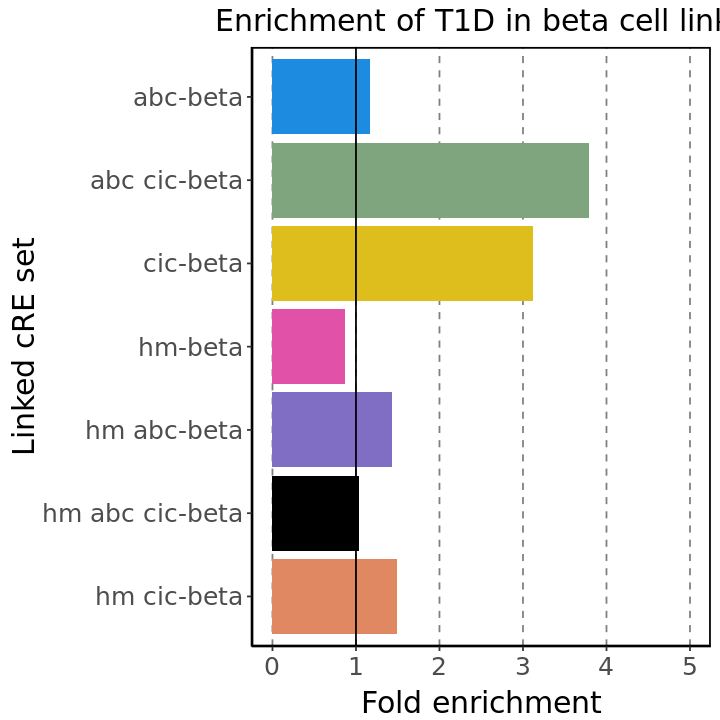

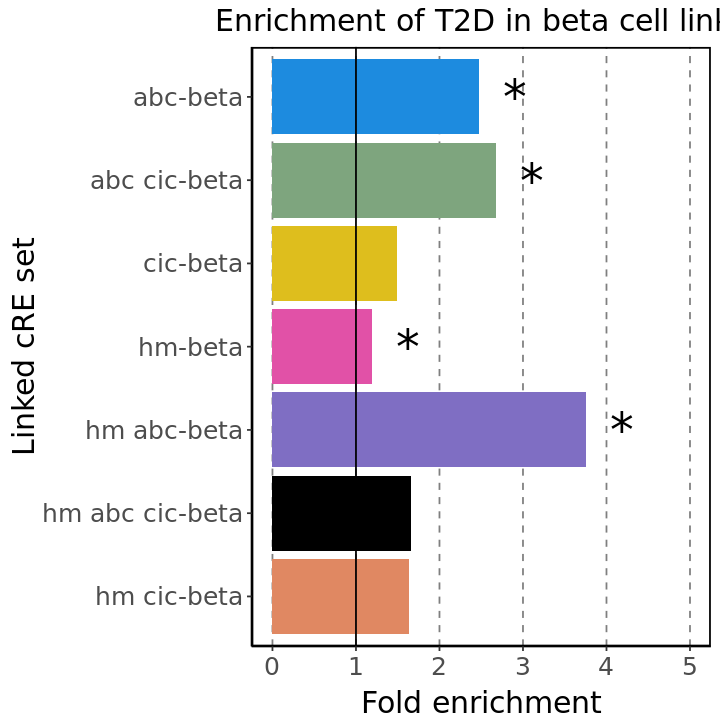

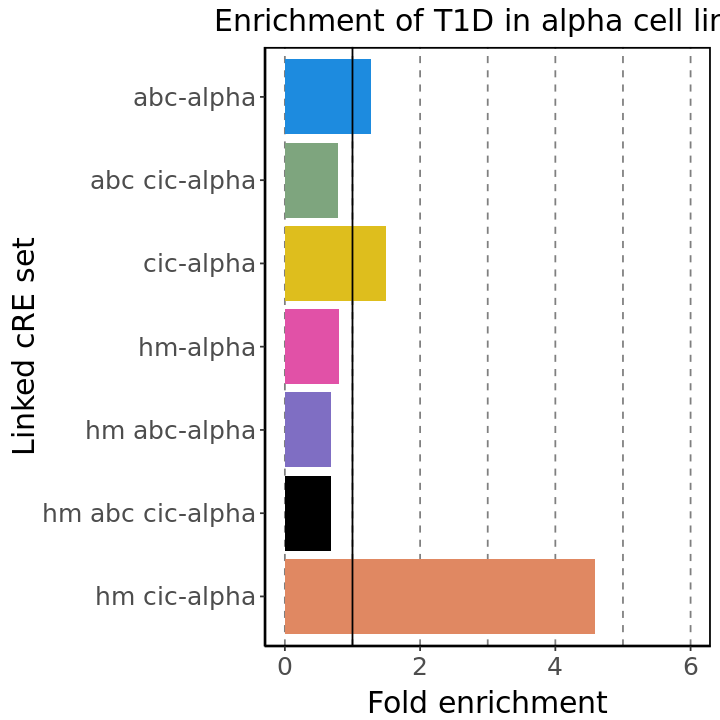

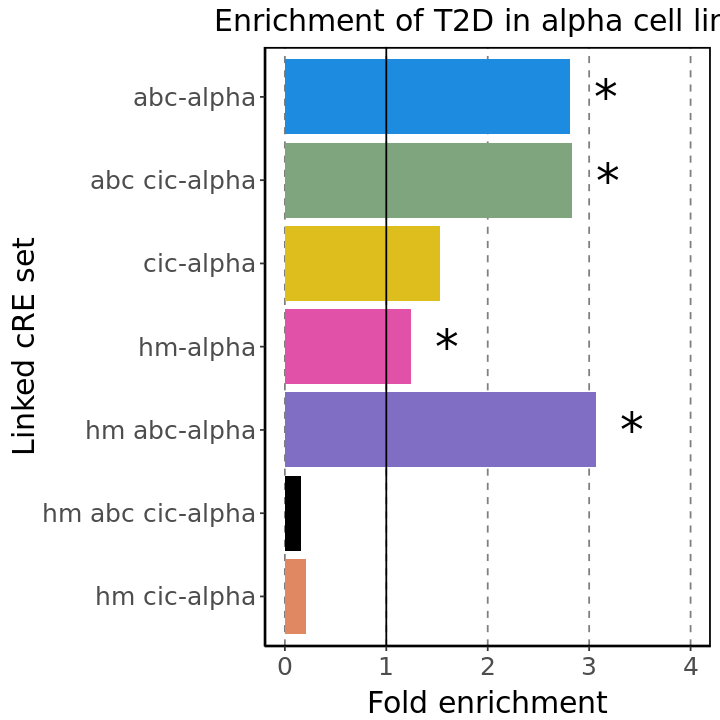

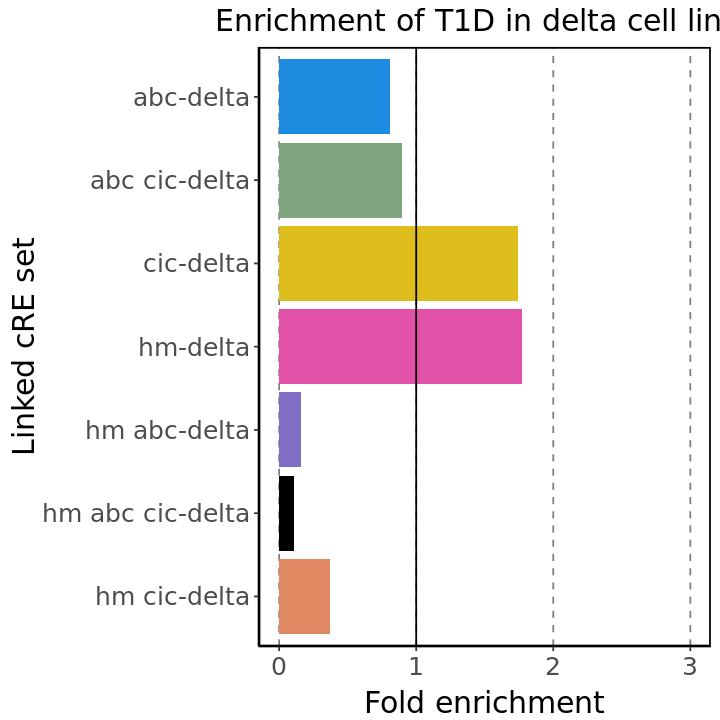

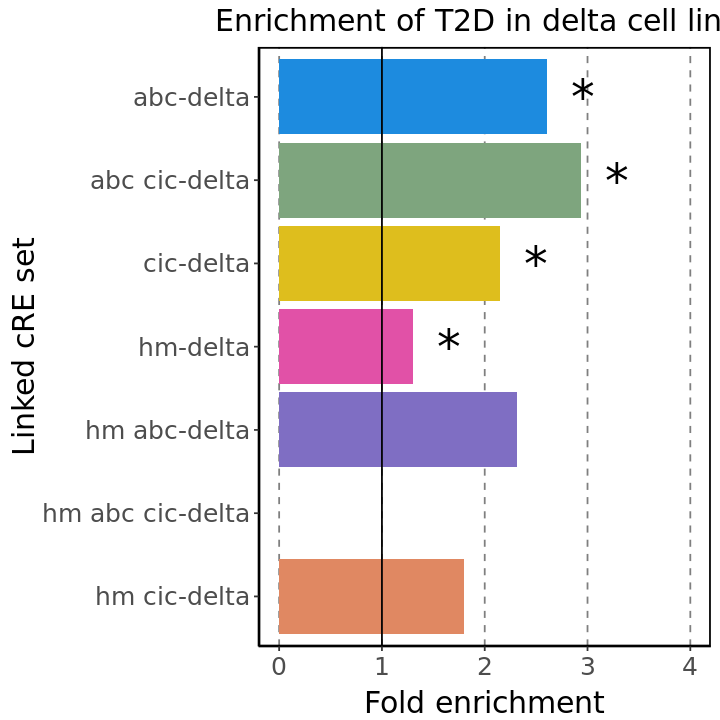

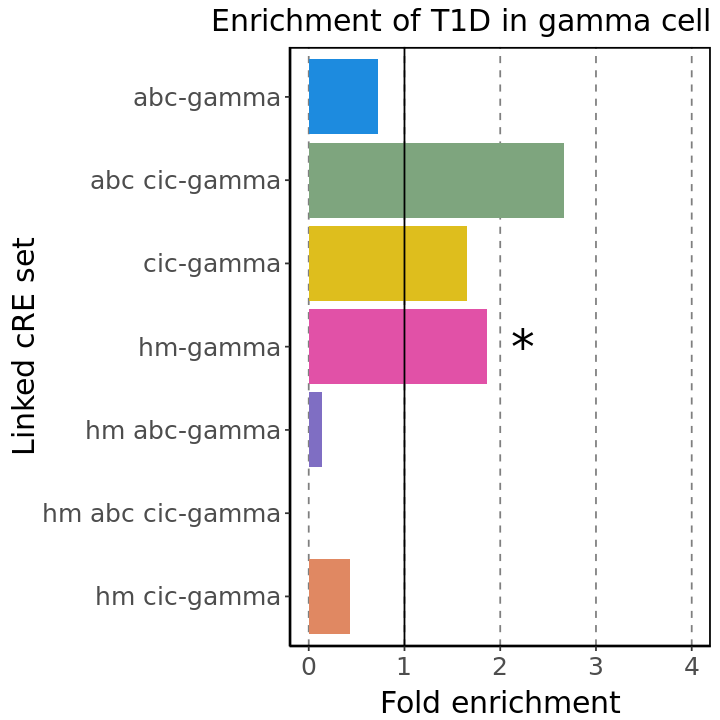

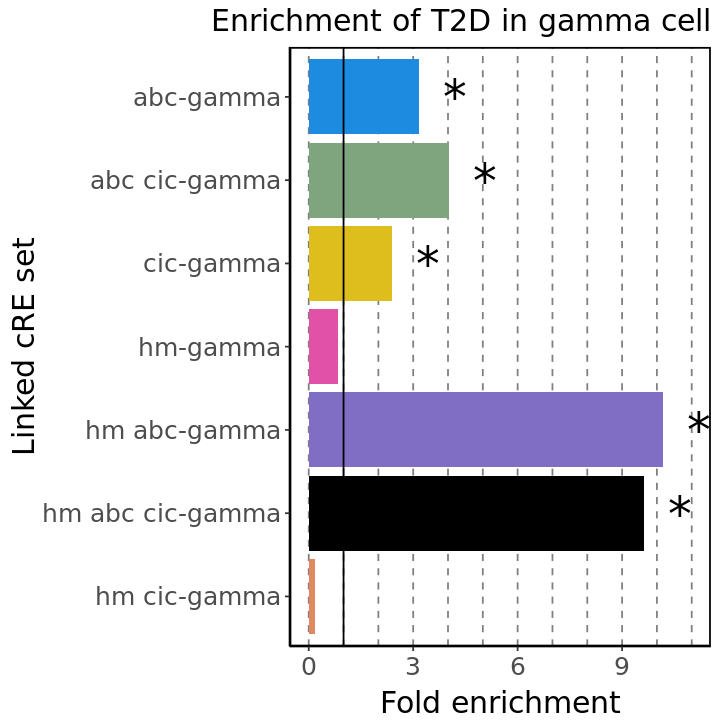

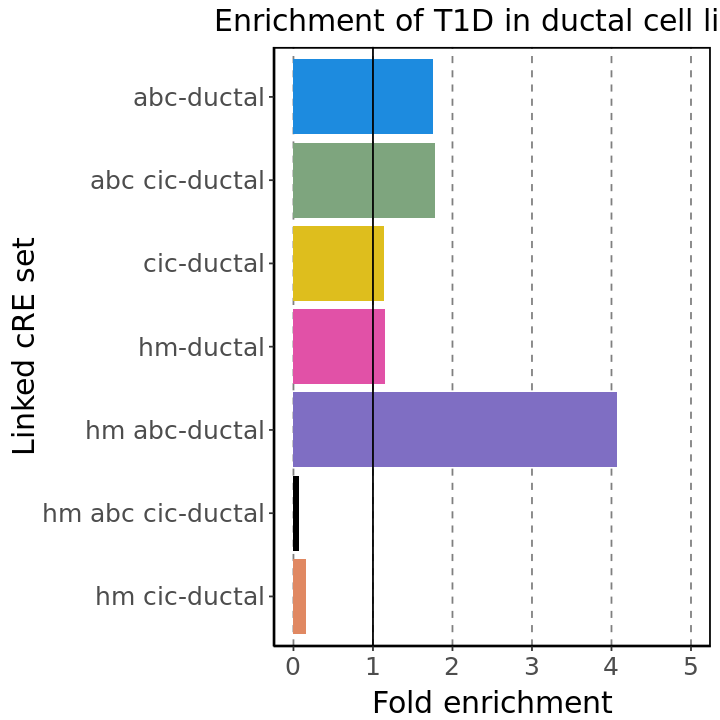

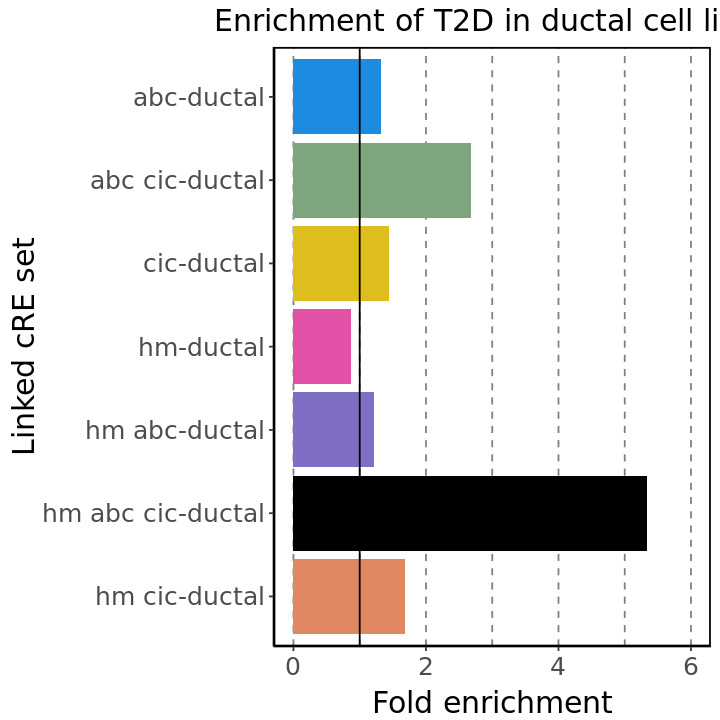

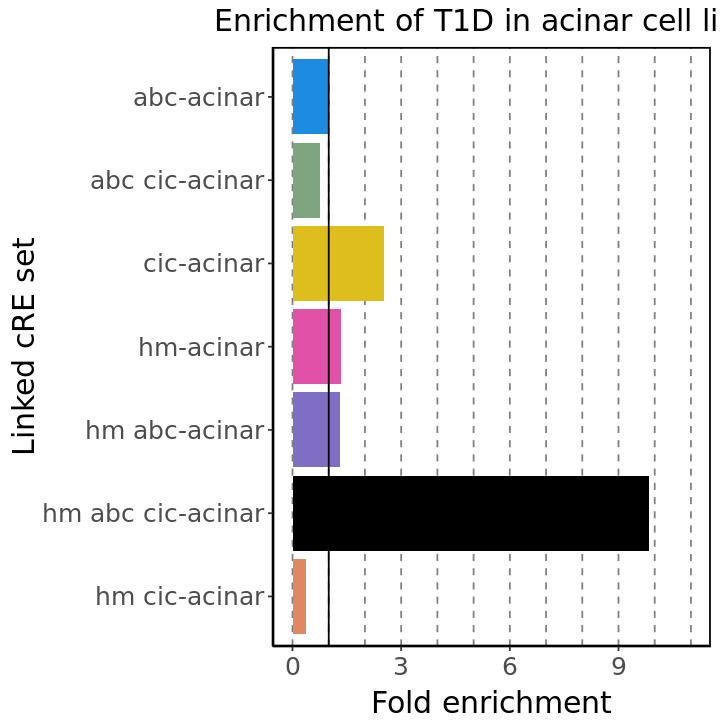

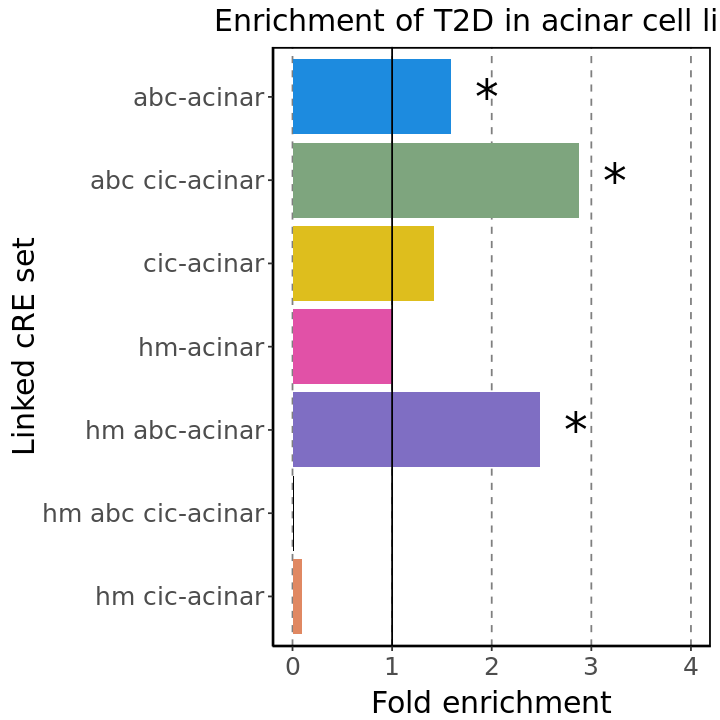

In [27]:
indir <- res_dir2
fp1 <- file.path(indir, 'T1D', 'combined_results_reformat.txt')
fp2 <- file.path(indir, 'T2D', 'combined_results_reformat.txt')

for (celltype in celltypes){
    #make colors vector for specific cell type and use names to cut down plots
    colors2 <- copy(overlap_colors)    
    names(colors2) <- paste(link_sets, celltype, sep='-')
    plot_finrich(fp1, colors2, names(colors2), sprintf('Enrichment of T1D in %s cell links',celltype))
    plot_finrich(fp2, colors2, names(colors2), sprintf('Enrichment of T2D in %s cell links',celltype))
}

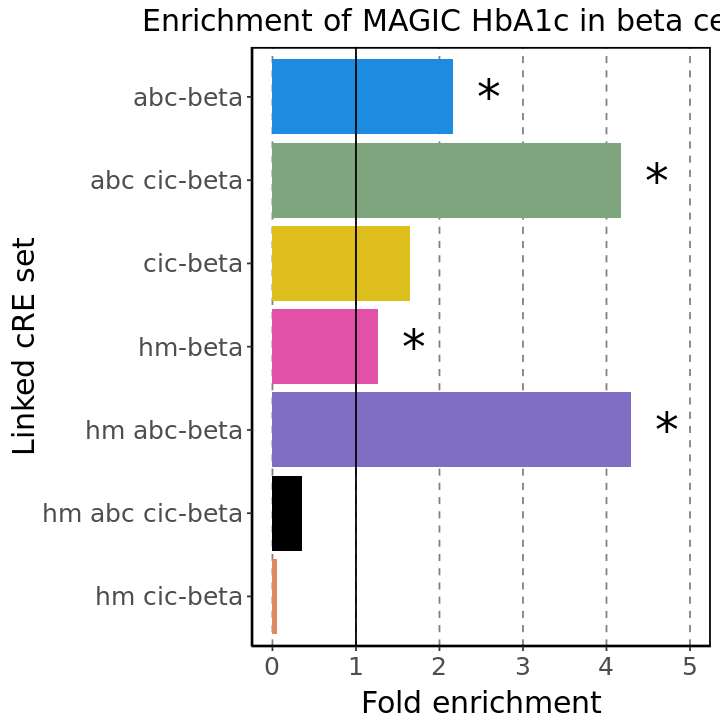

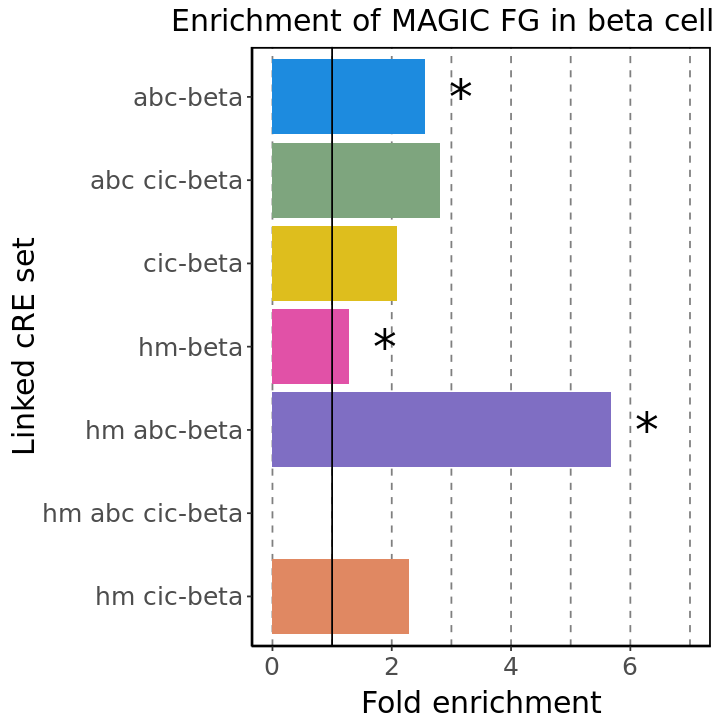

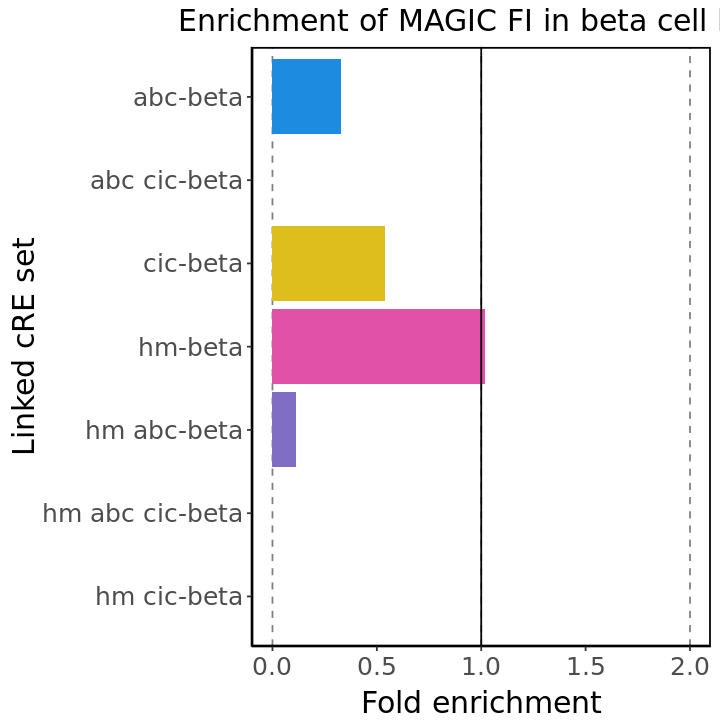

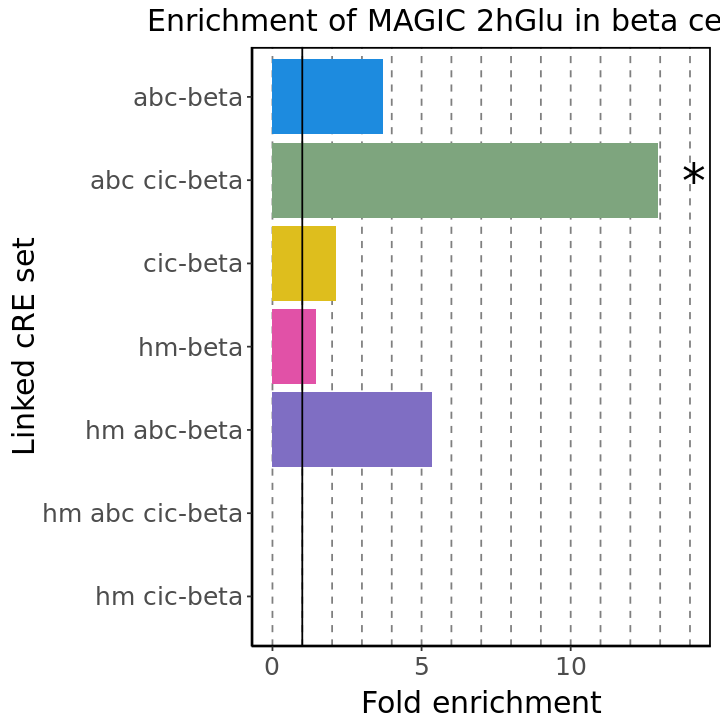

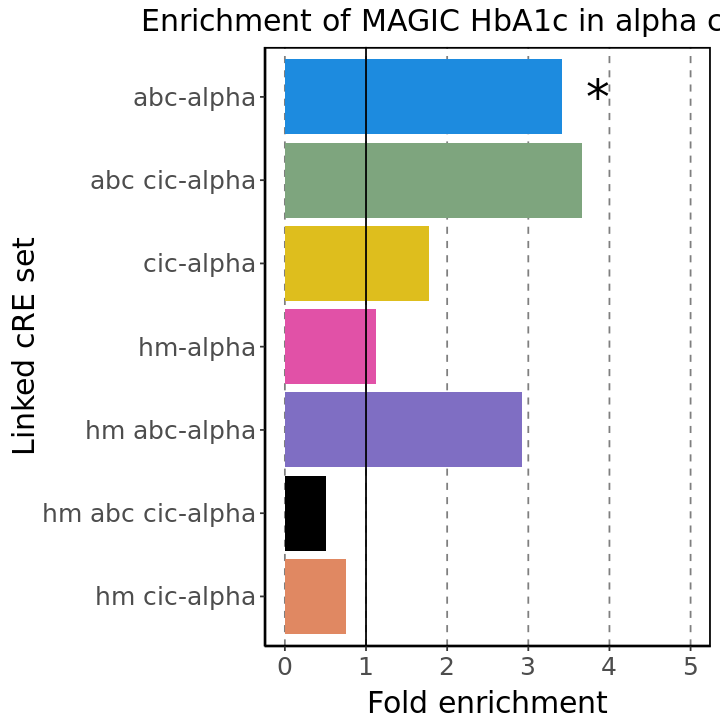

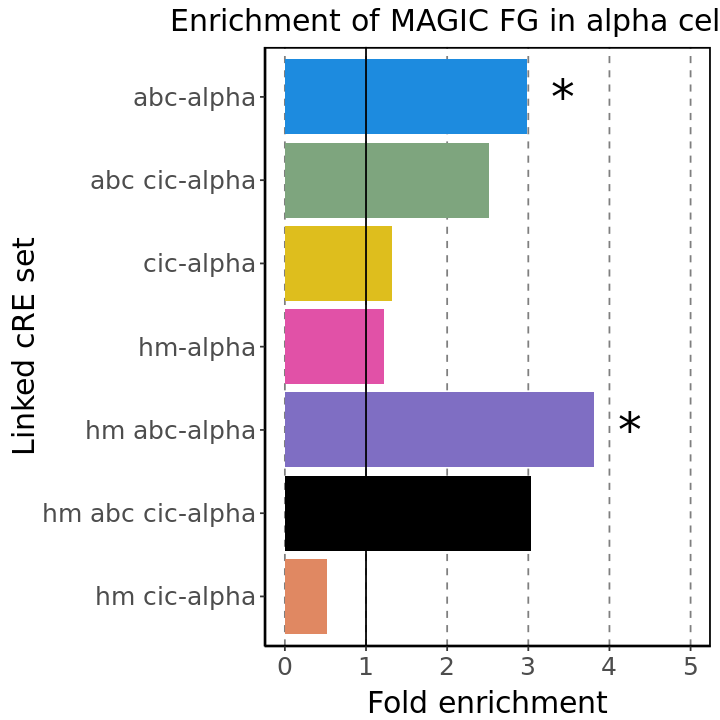

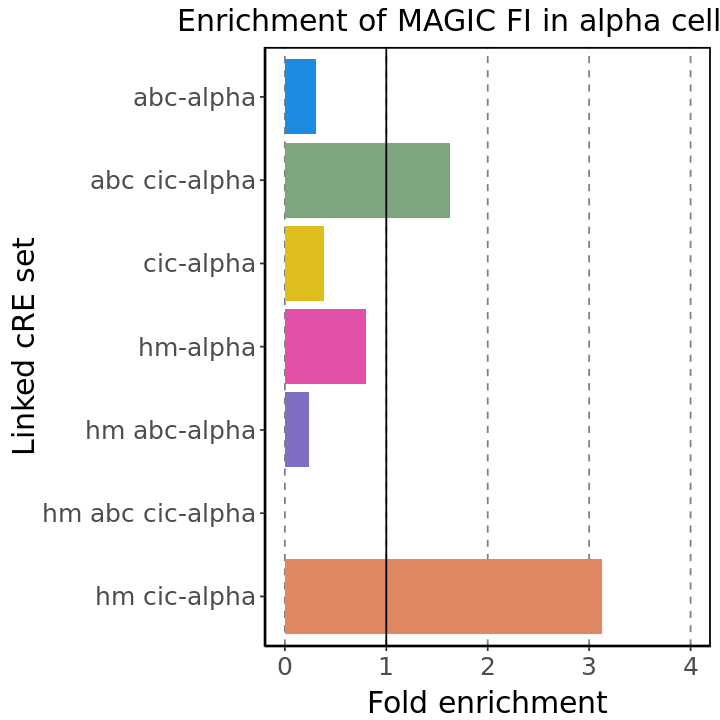

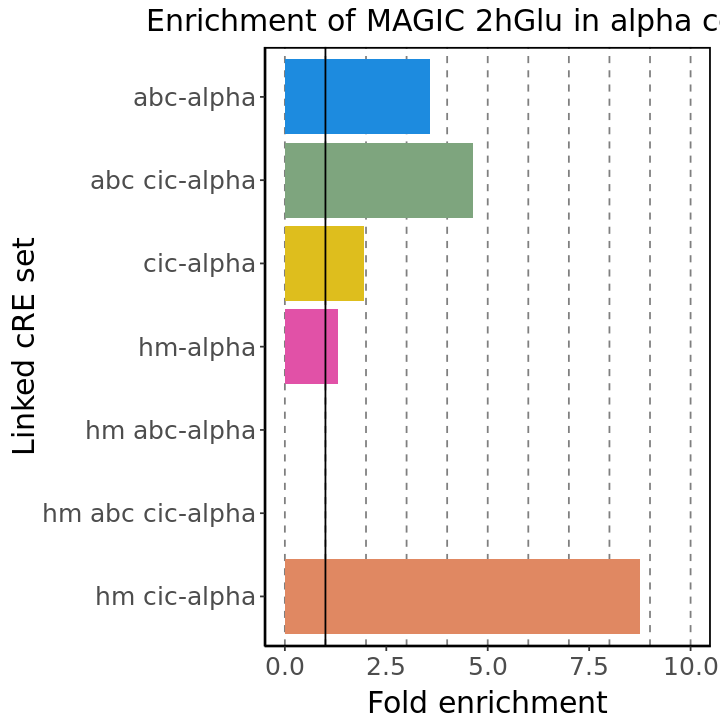

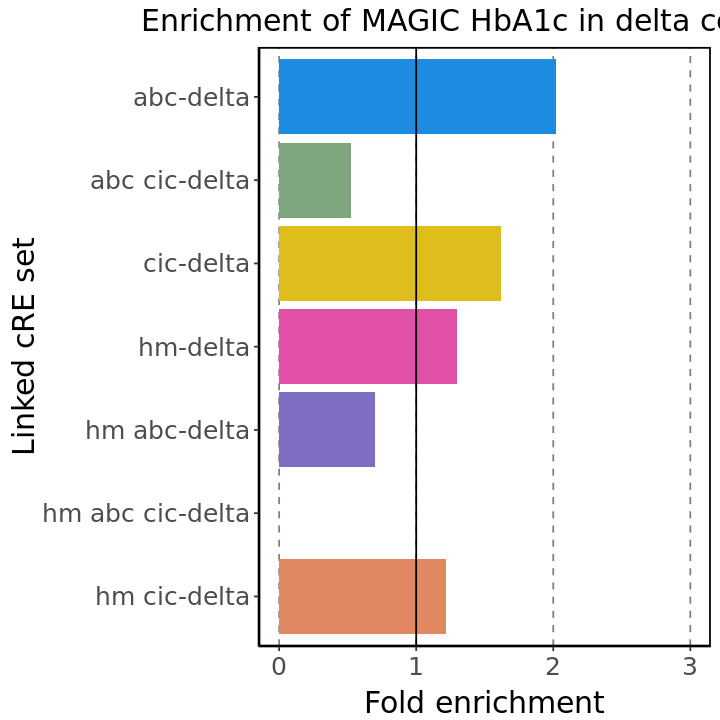

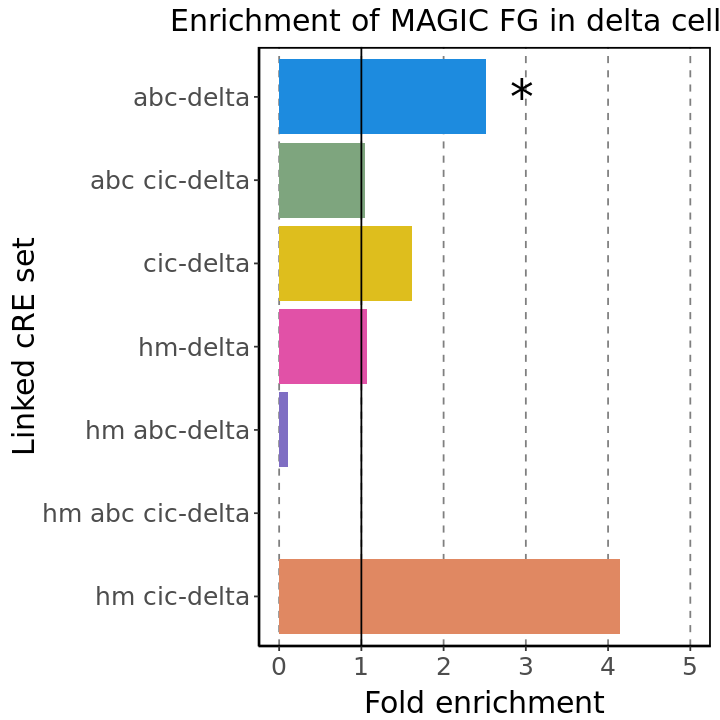

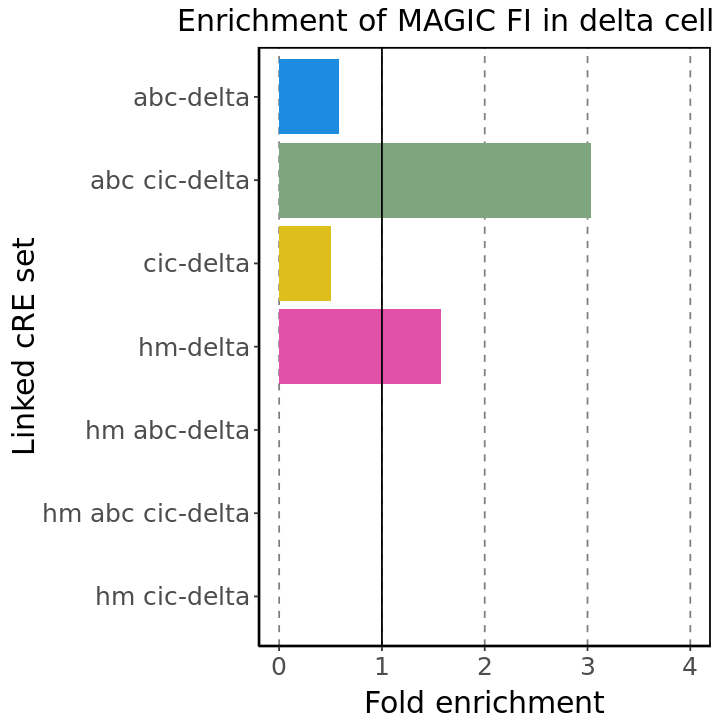

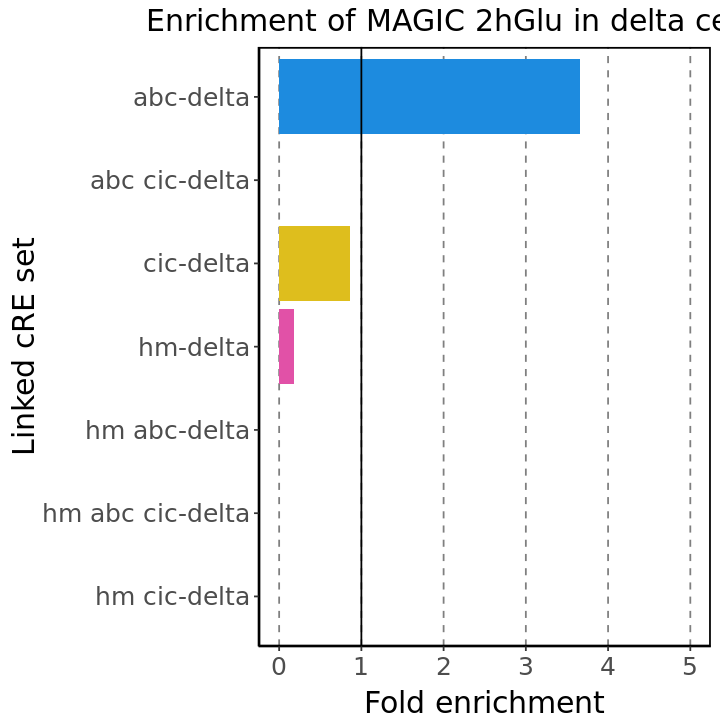

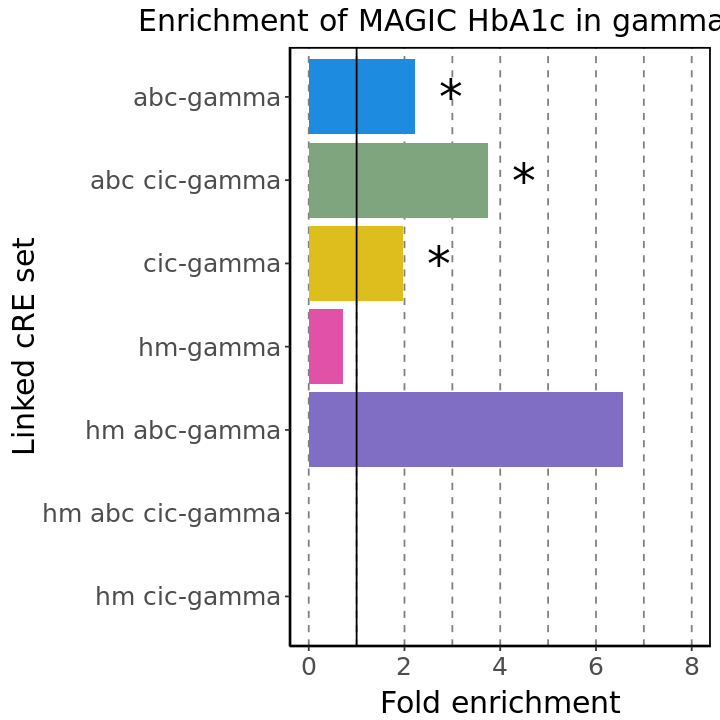

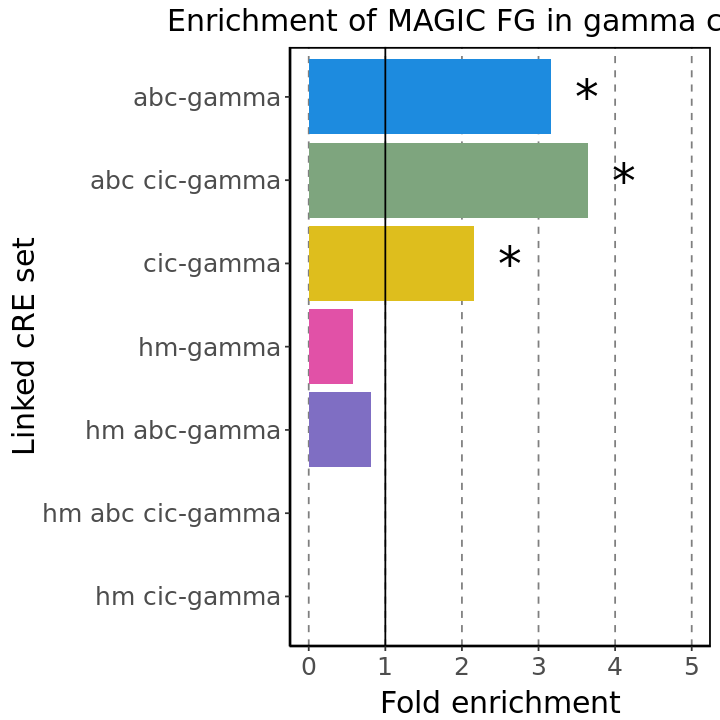

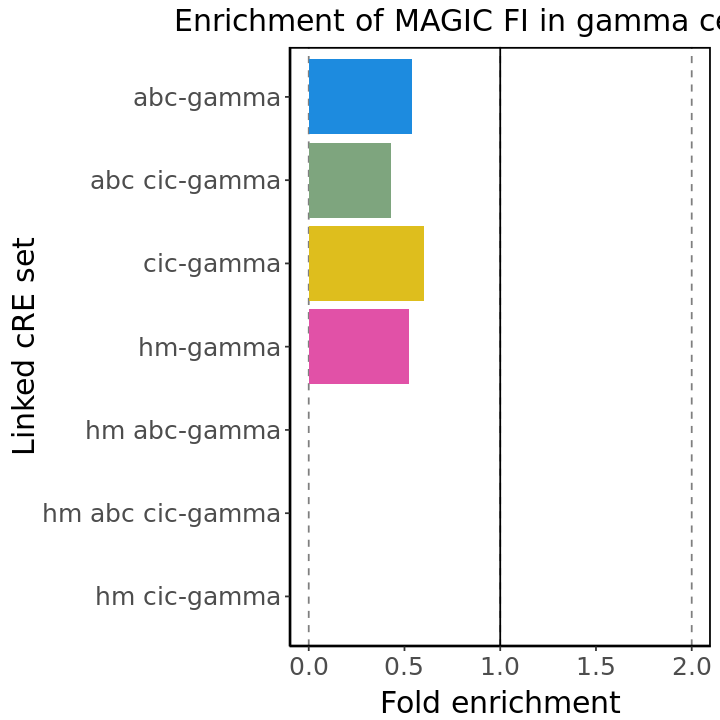

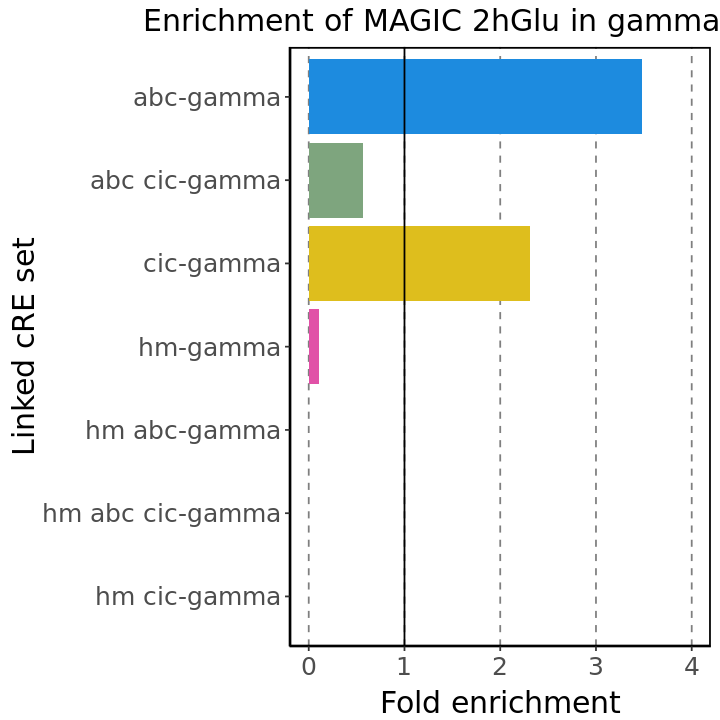

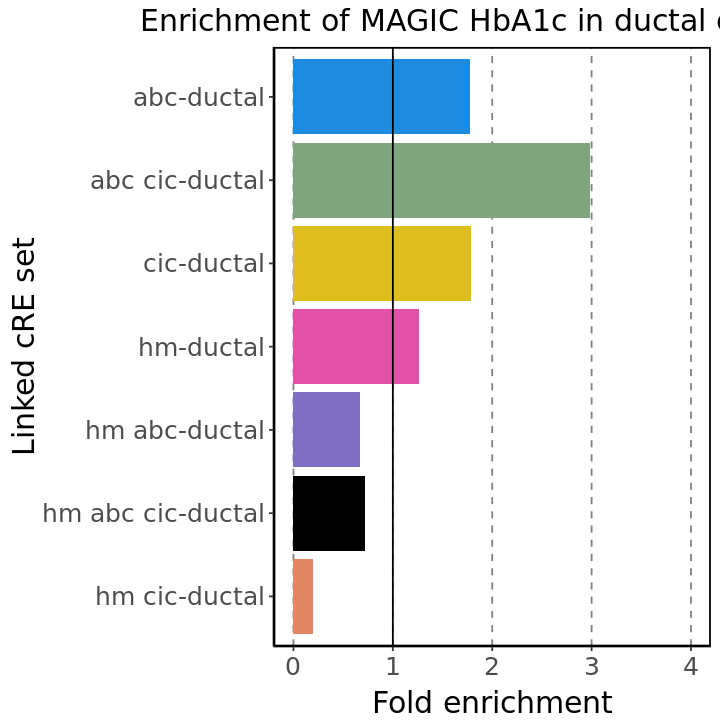

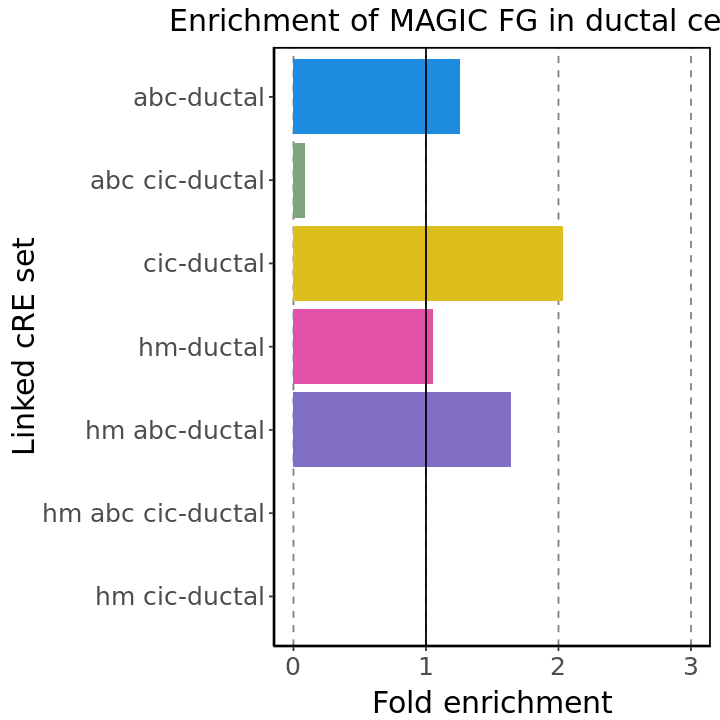

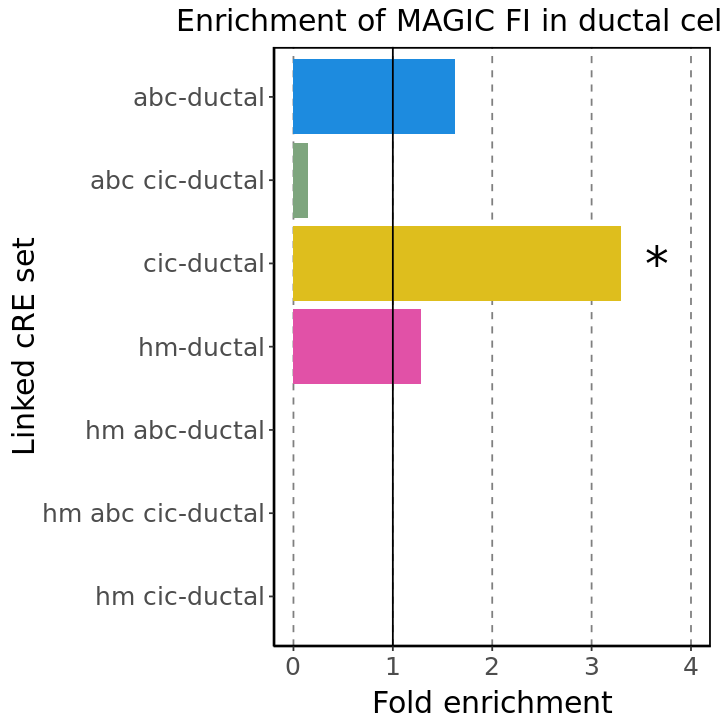

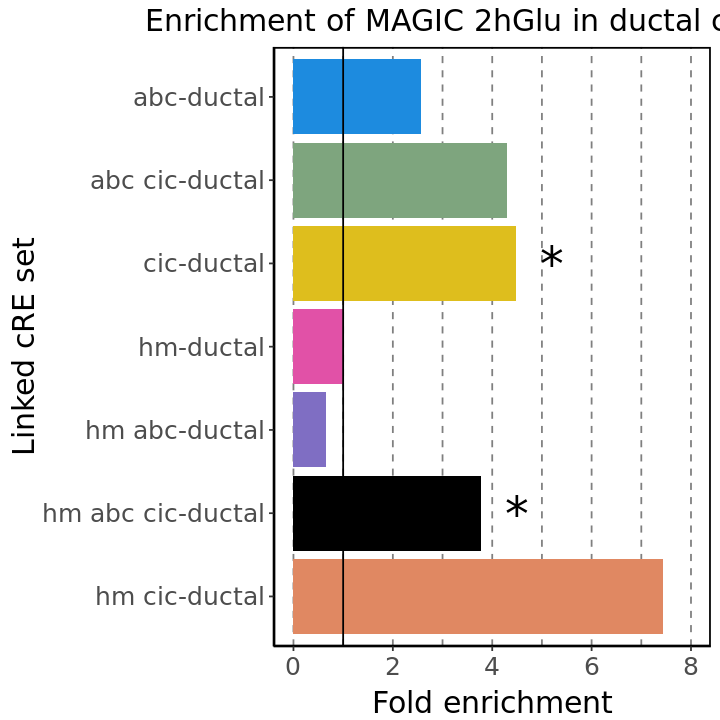

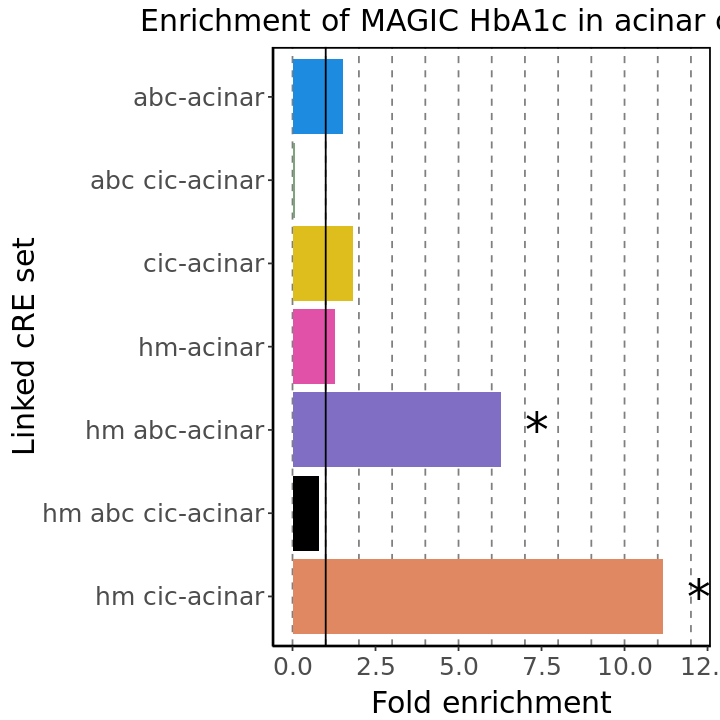

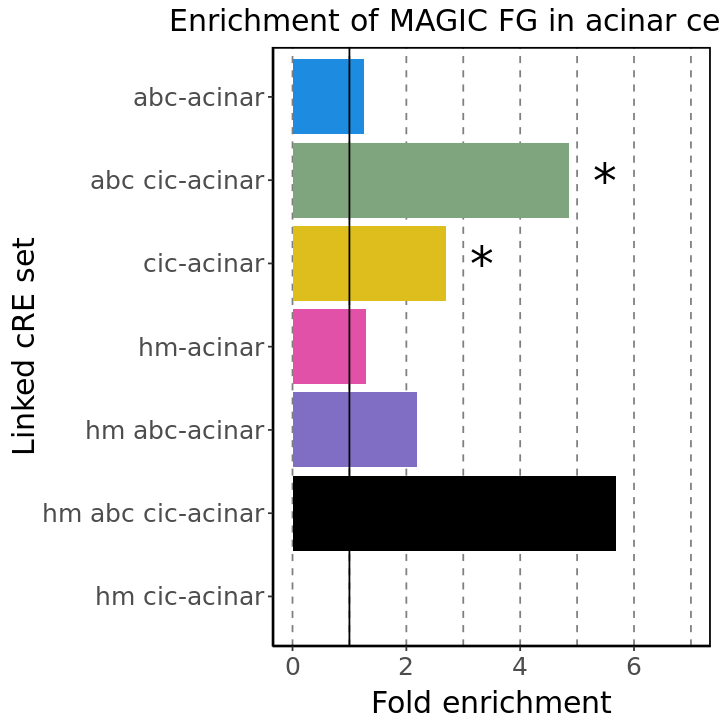

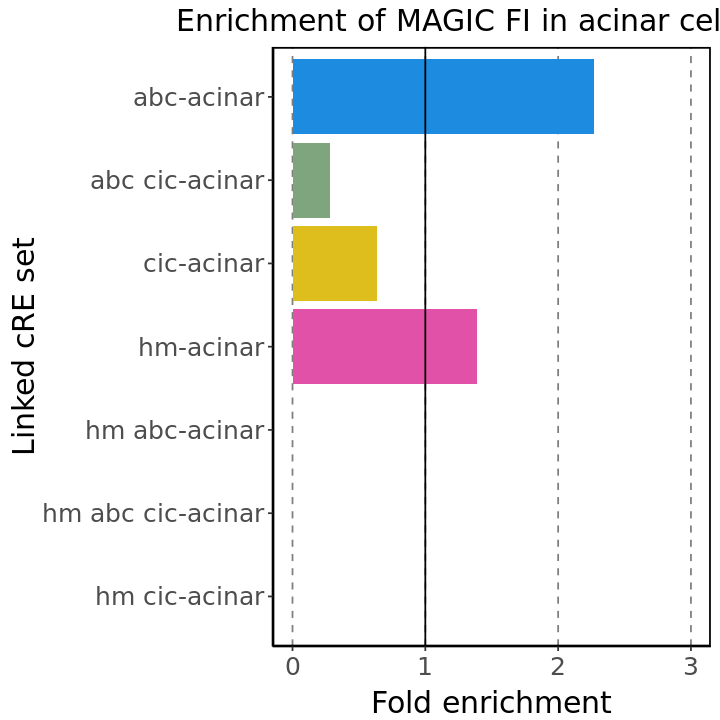

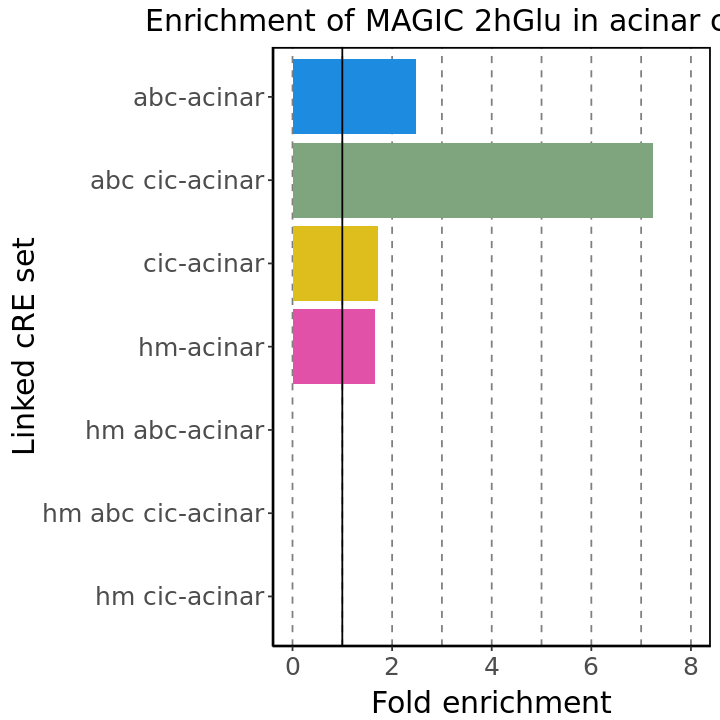

In [28]:
indir <- res_dir2
fp1 <- file.path(indir, 'HbA1c', 'combined_results_reformat.txt')
fp2 <- file.path(indir, 'FG', 'combined_results_reformat.txt')
fp3 <- file.path(indir, 'FI', 'combined_results_reformat.txt')
fp4 <- file.path(indir, '2hGlu', 'combined_results_reformat.txt')

for (celltype in celltypes){
    #make colors vector for specific cell type and use names to cut down plots
    colors2 <- copy(overlap_colors)    
    names(colors2) <- paste(link_sets, celltype, sep='-')
    plot_finrich(fp1, colors2, names(colors2), sprintf('Enrichment of MAGIC HbA1c in %s cell links',celltype))
    plot_finrich(fp2, colors2, names(colors2), sprintf('Enrichment of MAGIC FG in %s cell links',celltype))
    plot_finrich(fp3, colors2, names(colors2), sprintf('Enrichment of MAGIC FI in %s cell links',celltype))
    plot_finrich(fp4, colors2, names(colors2), sprintf('Enrichment of MAGIC 2hGlu in %s cell links',celltype))
}